In [62]:
import pandas as pd
import numpy as np
from torch.autograd import Variable
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn

# load a single file as a numpy array
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values


# load a list of files into a 3D array of [samples, timesteps, features]
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
      data = load_file(prefix + name)
      loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded


# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'HARDataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'HARDataset/')
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y

    trainX = Variable(torch.Tensor(trainX))
    trainy = Variable(torch.Tensor(trainy))
    testX = Variable(torch.Tensor(testX))
    testy = Variable(torch.Tensor(testy))
    print(trainX.size(), trainy.size())
    print(testX.size(), testy.size())
    
    return trainX, trainy, testX, testy
    

trainX, trainy, testX, testy = load_dataset('/home/proj01/dl_data/')



torch.Size([7352, 128, 9]) torch.Size([7352, 1])
torch.Size([2947, 128, 9]) torch.Size([2947, 1])


In [64]:
import torch.nn as nn
import torch

class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length) : 
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.softmax = nn.Softmax(dim=1)

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, 
        num_layers = num_layers, batch_first = True)

        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)

        self.relu = nn.ReLU()

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to('cuda:0') 
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to('cuda:0') 
        output, (hn, cn) = self.lstm(x, (h_0, c_0))

        hn = hn.view(-1, self.hidden_size) 
        out = self.relu(hn) 
        out = self.fc_1(out) 
        out = self.relu(out) 
        out = self.fc(out)
        out = self.softmax(out)
        return out

class CNN(nn.Module):
    def __init__(self, num_classes, num_channel):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=num_channel, out_channels=3, kernel_size=32, stride=1)
        self.conv2 = nn.Conv1d(in_channels=3, out_channels=10, kernel_size=16, stride=1)
        self.fc1 = nn.Linear(10 * 82, 50)
        self.fc2 = nn.Linear(50, num_classes)
        self.softmax = nn.Softmax(dim=1)
      
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 10 * 82)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.softmax(x)
        return x


In [92]:
# lstm parameters
epochs = 1000
learning_rate = 0.001
input_size = 9
hidden_size = 2
num_layers = 1
num_classes = 6
sequence_length = 128

lstm = LSTM(num_classes,input_size, hidden_size, num_layers, sequence_length).to('cuda:0')

loss_function = torch.nn.CrossEntropyLoss().to('cuda:0')
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [93]:
# lstm train
lstm.train()
lstm_losses = []
for e in range(epochs):
  outputs = lstm.forward(trainX.to('cuda:0'))
  optimizer.zero_grad()

  loss = loss_function(outputs,trainy.squeeze(dim=1).type(torch.LongTensor).to('cuda:0'))
  
  loss.backward()

  optimizer.step()

  if e%10 == 0:
    print("Epoch : %d, loss : %1.5f" % (e, loss.item()))
    lstm_losses.append(loss.item())

Epoch : 0, loss : 1.79088
Epoch : 10, loss : 1.78800
Epoch : 20, loss : 1.78620
Epoch : 30, loss : 1.78500
Epoch : 40, loss : 1.78403
Epoch : 50, loss : 1.78284
Epoch : 60, loss : 1.78090
Epoch : 70, loss : 1.77765
Epoch : 80, loss : 1.77230
Epoch : 90, loss : 1.76388
Epoch : 100, loss : 1.75106
Epoch : 110, loss : 1.73263
Epoch : 120, loss : 1.70908
Epoch : 130, loss : 1.68373
Epoch : 140, loss : 1.66141
Epoch : 150, loss : 1.64486
Epoch : 160, loss : 1.63381
Epoch : 170, loss : 1.62607
Epoch : 180, loss : 1.62003
Epoch : 190, loss : 1.61488
Epoch : 200, loss : 1.60998
Epoch : 210, loss : 1.60487
Epoch : 220, loss : 1.59937
Epoch : 230, loss : 1.59330
Epoch : 240, loss : 1.58652
Epoch : 250, loss : 1.57912
Epoch : 260, loss : 1.57120
Epoch : 270, loss : 1.56290
Epoch : 280, loss : 1.55432
Epoch : 290, loss : 1.54559
Epoch : 300, loss : 1.53680
Epoch : 310, loss : 1.52801
Epoch : 320, loss : 1.51918
Epoch : 330, loss : 1.51031
Epoch : 340, loss : 1.50139
Epoch : 350, loss : 1.49231
Epo

In [94]:
# lstm eval
def accuracy(outputs, labels):
  _,preds = torch.max(outputs,dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds))

lstm.eval()
lstm_out = lstm(testX.to('cuda:0'))

loss = loss_function(lstm_out,testy.squeeze(dim=1).type(torch.LongTensor).to('cuda:0'))
acc = accuracy(lstm_out,testy.squeeze(dim=1).type(torch.LongTensor).to('cuda:0'))

print(loss,acc)

tensor(1.4208, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.6250)


In [98]:
# cnn parameters
epochs = 1000
learning_rate = 0.001
input_size = 9
hidden_size = 2
num_layers = 1
num_classes = 6
sequence_length = 128
num_channel = 9 # for cnn

cnn = CNN(num_classes,num_channel).to('cuda:0')

loss_function = torch.nn.CrossEntropyLoss().to('cuda:0')
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

In [99]:
# cnn train
cnn.train()
cnn_losses = []
for e in range(epochs):
  outputs = cnn.forward(trainX.transpose(1,2).to('cuda:0'))
  optimizer.zero_grad()

  loss = loss_function(outputs,trainy.squeeze(dim=1).type(torch.LongTensor).to('cuda:0'))
  
  loss.backward()

  optimizer.step()

  if e%10 == 0:
    print("Epoch : %d, loss : %1.5f" % (e, loss.item()))
    cnn_losses.append(loss.item())

Epoch : 0, loss : 1.79211
Epoch : 10, loss : 1.75615
Epoch : 20, loss : 1.63434
Epoch : 30, loss : 1.53445
Epoch : 40, loss : 1.41956
Epoch : 50, loss : 1.30189
Epoch : 60, loss : 1.23703
Epoch : 70, loss : 1.20252
Epoch : 80, loss : 1.18123
Epoch : 90, loss : 1.14890
Epoch : 100, loss : 1.12525
Epoch : 110, loss : 1.11592
Epoch : 120, loss : 1.10957
Epoch : 130, loss : 1.10524
Epoch : 140, loss : 1.10207
Epoch : 150, loss : 1.09972
Epoch : 160, loss : 1.09796
Epoch : 170, loss : 1.09664
Epoch : 180, loss : 1.09565
Epoch : 190, loss : 1.09492
Epoch : 200, loss : 1.09433
Epoch : 210, loss : 1.09382
Epoch : 220, loss : 1.09337
Epoch : 230, loss : 1.09299
Epoch : 240, loss : 1.09267
Epoch : 250, loss : 1.09240
Epoch : 260, loss : 1.09214
Epoch : 270, loss : 1.09192
Epoch : 280, loss : 1.09172
Epoch : 290, loss : 1.09155
Epoch : 300, loss : 1.09140
Epoch : 310, loss : 1.09126
Epoch : 320, loss : 1.09113
Epoch : 330, loss : 1.09101
Epoch : 340, loss : 1.09094
Epoch : 350, loss : 1.09087
Epo

In [102]:
# cnn eval
def accuracy(outputs, labels):
  _,preds = torch.max(outputs,dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds))

cnn.eval()
cnn_out = cnn(testX.transpose(1,2).to('cuda:0'))

loss = loss_function(cnn_out,testy.squeeze(dim=1).type(torch.LongTensor).to('cuda:0'))
acc = accuracy(cnn_out,testy.squeeze(dim=1).type(torch.LongTensor).to('cuda:0'))

print(loss,acc)

tensor(1.1641, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.8785)


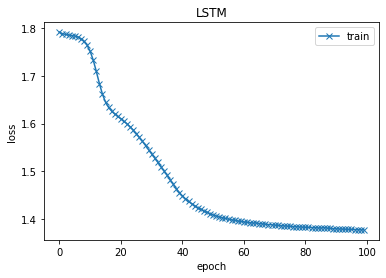

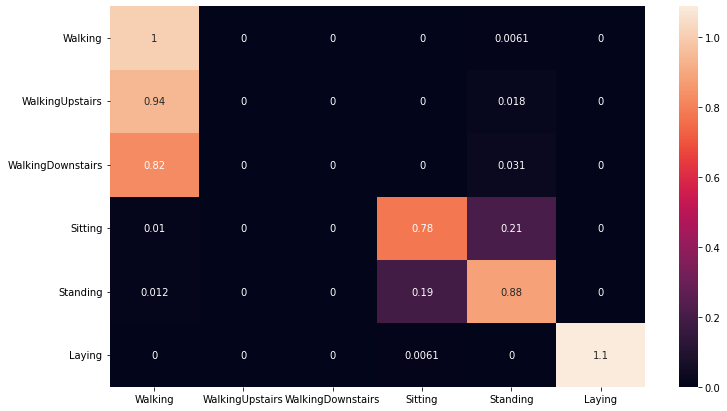

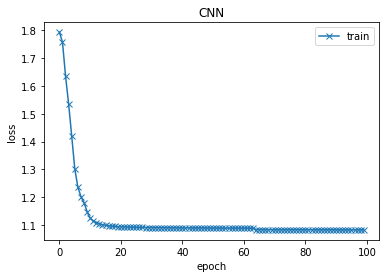

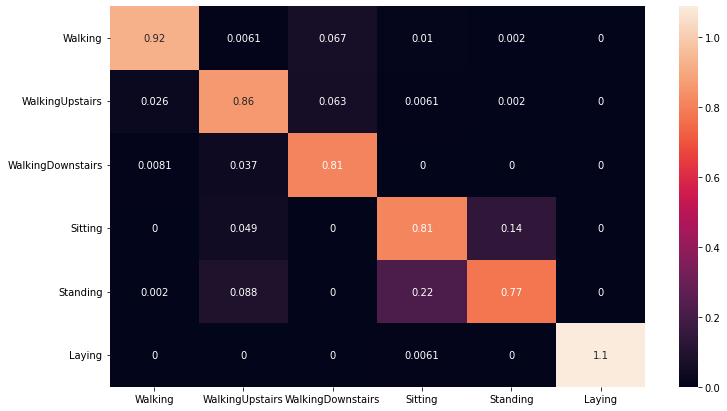

In [103]:
def graph(name,losses,preds,label,name_classes):
    plt.plot(losses, '-x',label='train')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title(name)
    plt.legend()
    plt.show()
    cf_matrix = confusion_matrix(label.squeeze(dim=1).detach().numpy(),torch.max(preds,1)[1].cpu().detach().numpy())
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix)*len(name_classes), index = name_classes, columns = name_classes)
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm,annot=True)
    plt.show()

name_classes = ['Walking','WalkingUpstairs','WalkingDownstairs','Sitting','Standing','Laying']
graph('LSTM',lstm_losses,lstm_out,testy,name_classes)
graph('CNN',cnn_losses,cnn_out,testy,name_classes)